# Factorization Machine & Field Aware Factorization Machine

Factorization machines (FM) [Rendle, 2010], proposed by Steffen Rendle in 2010, is a supervised algorithm that can be used for classification, regression, and ranking tasks. It quickly took notice and became a popular and impactful method for making predictions and recommendations. Particularly, it is a generalization of the linear regression model and the matrix factorization model. Moreover, it is reminiscent of support vector machines with a polynomial kernel. 

This notebook presents a deep dive into the Factorization Machine algorithm, and demonstrates some best practices of using the contemporary FM implementations like xlearn for dealing with tasks like click-through rate prediction, whether the customer purchased the product or not?.

<h3> Limitations of other Recommendation Algorithms like SVM, poly2 </h3>

In certain occasions, the data that appears in recommendation problems, such as user, item, and feature vectors, can be encoded into a one-hot representation. Under this arrangement, classical algorithms like linear regression and SVM may suffer from the following problems:

  The feature vectors are highly sparse, and thus it makes it hard to optimize the parameters to fit the model efficienly
  
  Cross-product of features will be sparse as well, and this in turn, reduces the expressiveness of a model if it is designed to capture the high-order interactions between features

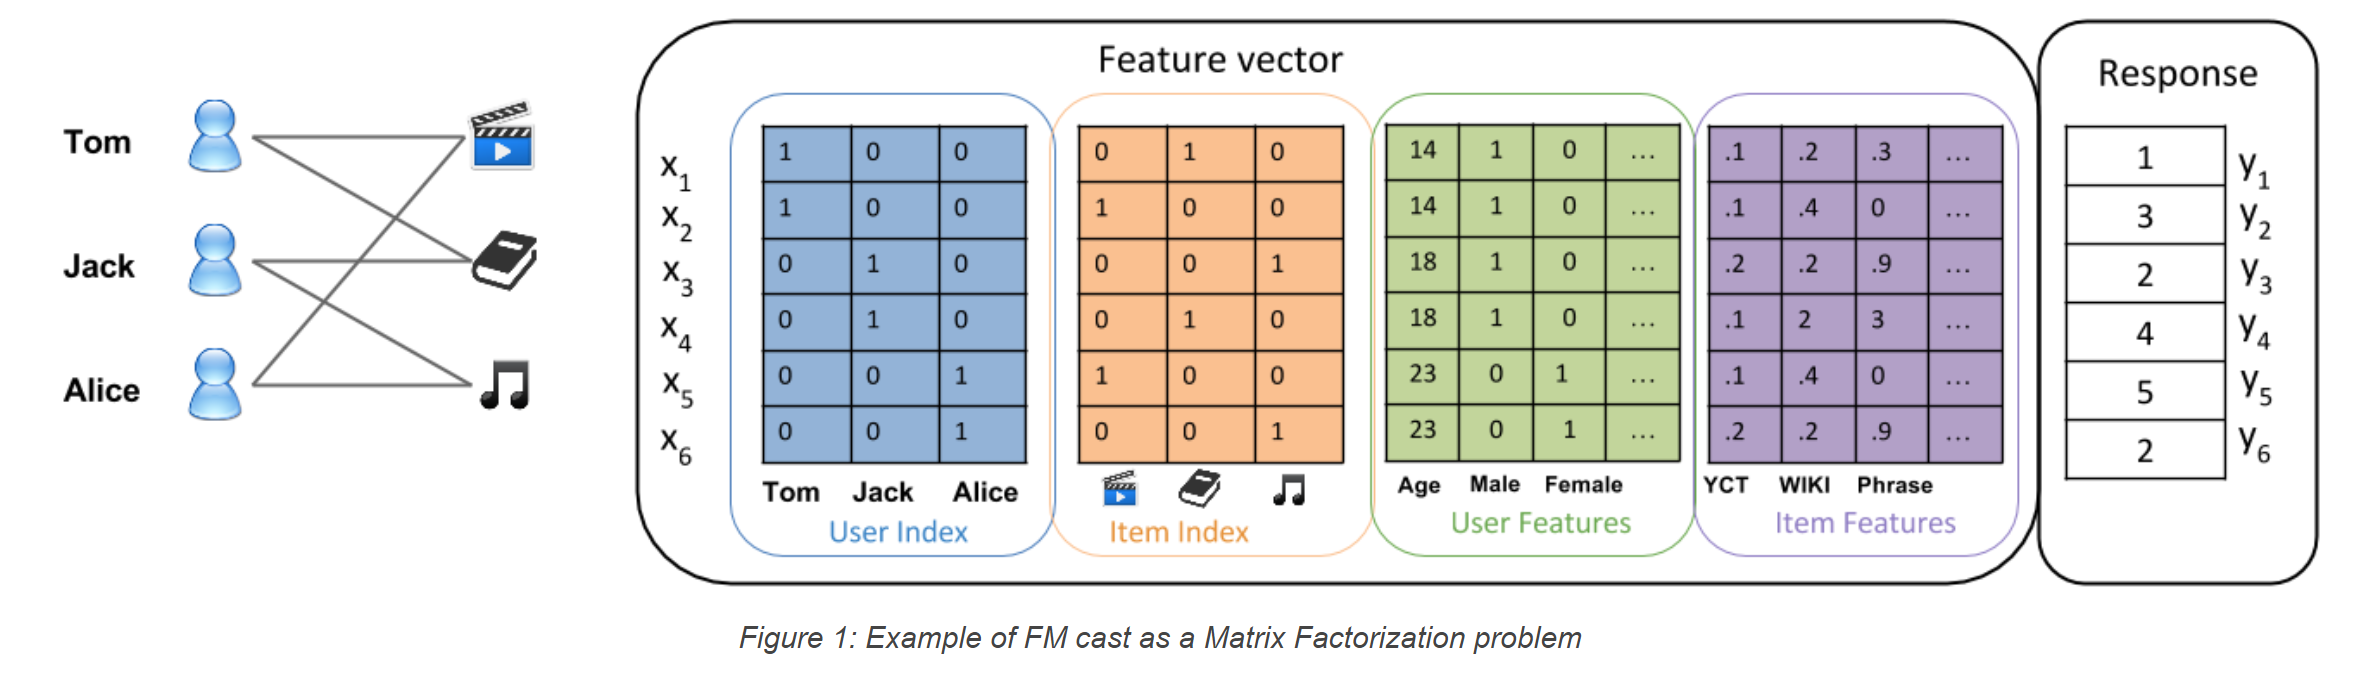

In [3]:
from IPython.display import Image
Image(filename='FM.png',width=800, height=400)

# Importing the dependencies

In [1]:
import time
import sys
sys.path.append("../../")
import os
from tempfile import TemporaryDirectory
import xlearn as xl
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib notebook
from matplotlib import pyplot as plt

from reco_utils.common.constants import SEED
from reco_utils.common.timer import Timer
from reco_utils.recommender.deeprec.deeprec_utils import (
    download_deeprec_resources, prepare_hparams
)
from reco_utils.recommender.deeprec.models.xDeepFM import XDeepFMModel
from reco_utils.recommender.deeprec.IO.iterator import FFMTextIterator
from reco_utils.tuning.parameter_sweep import generate_param_grid
from reco_utils.dataset.pandas_df_utils import LibffmConverter

print("System version: {}".format(sys.version))
print("Xlearn version: {}".format(xl.__version__))

System version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Xlearn version: 0.4.4


<h3> For FM/FFM our data should be in libsvm/libffm format </h3>

In the FM model building, data is usually represented in the libsvm data format. That is, label feat1:val1 feat2:val2 ..., where label is the target to predict, and val is the value to each feature feat.

FFM algorithm requires data to be represented in the libffm format, where each vector is split into several fields with categorical/numerical features inside. That is, label field1:feat1:val1 field2:feat2:val2 ....

In the Microsoft/Recommenders utility functions, a libffm converter is provided to achieve the transformation from a tabular feature vectors to the corresponding libffm representation. For example, the following shows how to transform the format of a synthesized data by using the module of LibffmConverter.

<b> Example data to understand how it converts to libffm format </b>

<img src="img1.png" width="600" height="400">

When we talk about FMs or FFMs, each column (Publisher, Advertiser…) in the dataset would be referred to as a field and each value (ESPN, Nike….) would be referred to as a feature.

For using FMs on datasets, it needs to be converted to a specific format called the libSVM format. The format of training and testing data file is:

<b> {label} {feature1}:{value1} {feature2}:{value2} … </b>
 
<img src="img2.png" width="600" height="400">
 
In case of a categorical field, the feature is uniquely encoded and a value of 1 is assigned to it. In the above figure ESPN is represented by code 1, Nike is represented by code 2 and so on. Each line contains an equivalent training example and is ended by a ‘\n’ or a new line character.

For classification(binary/multiclass), <label> is an integer indicating the class label.
For regression, <label> is the target value which can be any real number.
Labels in the test file are only used to calculate accuracy or errors. If they are unknown, you can just fill the first column with any number.
    
<img src="img3.png" width="600" height="400">

Similarly for FFMs, the data needs to be transformed to a libffm format. Here, we also need to encode the field since ffm requires the information of field for learning. The format for the same is:

<b> {label}{field1}:{feature1}:{value1} {field2}:{feature2}:{value2} …..</b>


In [2]:
df_feature_original = pd.DataFrame({
    'purchase or not': [1, 0, 0, 1, 1,1],
    'month': ['nov', 'jan', 'march', 'dec', 'oct','feb'],
    'price': [3, 4, 5, 6, 7,6],
    'year': [2019, 2018, 2017, 2020, 2019,2018],
    'category': ['asian snack', 'japanese snack', 'protien snack', 'keto diet snack', 'candies','american snack']
})

converter = LibffmConverter().fit(df_feature_original, col_rating='purchase or not')
df_out = converter.transform(df_feature_original)
df_out

,purchase or not,month,price,year,category
0,1,1:1:1,2:7:3,3:8:2019,4:9:1
1,0,1:2:1,2:7:4,3:8:2018,4:10:1
2,0,1:3:1,2:7:5,3:8:2017,4:11:1
3,1,1:4:1,2:7:6,3:8:2020,4:12:1
4,1,1:5:1,2:7:7,3:8:2019,4:13:1
5,1,1:6:1,2:7:6,3:8:2018,4:14:1


<h3> Total number of fields and features in our dataset </h3>

In [3]:
print('There are in total {0} fields and {1} features.'.format(converter.field_count, converter.feature_count))

There are in total 4 fields and 14 features.


# Parameters for our model

In [4]:
# Parameters
YAML_FILE_NAME = "xDeepFM.yaml"
TRAIN_FILE_NAME = "cretio_tiny_train"
VALID_FILE_NAME = "cretio_tiny_valid"
TEST_FILE_NAME = "cretio_tiny_test"
MODEL_FILE_NAME = "model.out"
OUTPUT_FILE_NAME = "output.txt"

LEARNING_RATE = 0.2
LAMBDA = 0.002
# The metrics for binary classification options are "acc", "prec", "f1" and "auc"
# for regression, options are "rmse", "mae", "mape"
METRIC = "auc" 
EPOCH = 10
OPT_METHOD = "sgd" # options are "sgd", "adagrad" and "ftrl"

In [5]:
tmpdir = TemporaryDirectory()

data_path = tmpdir.name
yaml_file = os.path.join(data_path, YAML_FILE_NAME)
train_file = os.path.join(data_path, TRAIN_FILE_NAME)
valid_file = os.path.join(data_path, VALID_FILE_NAME)
test_file = os.path.join(data_path, TEST_FILE_NAME)
model_file = os.path.join(data_path, MODEL_FILE_NAME)
output_file = os.path.join(data_path, OUTPUT_FILE_NAME)

if not os.path.exists(yaml_file):
    download_deeprec_resources(r'https://recodatasets.blob.core.windows.net/deeprec/', data_path, 'xdeepfmresources.zip')

100%|████████████████████████████████████████████████████████████████████████████| 10.3k/10.3k [00:01<00:00, 5.98kKB/s]


<h3> Training our model using Field Aware Factorization Machine </h3>

In [6]:
# Training task
ffm_model = xl.create_ffm()        # Use field-aware factorization machine (ffm)
ffm_model.setTrain(train_file)     # Set the path of training dataset
ffm_model.setValidate(valid_file)  # Set the path of validation dataset

# Parameters:
#  0. task: binary classification
#  1. learning rate: 0.2
#  2. regular lambda: 0.002
#  3. evaluation metric: auc
#  4. number of epochs: 10
#  5. optimization method: sgd
param = {"task":"binary", 
         "lr": LEARNING_RATE, 
         "lambda": LAMBDA, 
         "metric": METRIC,
         "epoch": EPOCH,
         "opt": OPT_METHOD
        }

# Start to train
# The trained model will be stored in model.out
with Timer() as time_train:
    ffm_model.fit(param, model_file)

# Prediction task
ffm_model.setTest(test_file)  # Set the path of test dataset
ffm_model.setSign()        # Convert output to 0-1

# Start to predict
# The output result will be stored in output.txt
with Timer() as time_predict:
    ffm_model.predict(model_file, output_file)

<h3> Compare the test file and the output file and compute the auc score for our evaluation </h3>

In [8]:
with open(output_file) as f:
    predictions = f.readlines()

with open(test_file) as f:
    truths = f.readlines()

truths = np.array([float(truth.split(' ')[0]) for truth in truths])
predictions = np.array([float(prediction.strip('')) for prediction in predictions])

auc_score = roc_auc_score(truths, predictions)


In [9]:
auc_score

0.6352643491619379

In [10]:
param_dict = {
    "lr": [0.0001, 0.001, 0.01],
    "lambda": [0.001, 0.01, 0.1]
    
}

param_grid = generate_param_grid(param_dict)

In [11]:
auc_scores = []

with Timer() as time_tune:
    for param in param_grid:
        ffm_model = xl.create_ffm()       
        ffm_model.setTrain(train_file)     
        ffm_model.setValidate(valid_file)
        ffm_model.fit(param, model_file)

        ffm_model.setTest(test_file)  
        ffm_model.setSign()        
        ffm_model.predict(model_file, output_file)

        with open(output_file) as f:
            predictions = f.readlines()

        with open(test_file) as f:
            truths = f.readlines()

        truths = np.array([float(truth.split(' ')[0]) for truth in truths])
        predictions = np.array([float(prediction.strip('')) for prediction in predictions])

        auc_scores.append(roc_auc_score(truths, predictions))

In [12]:
auc_scores = [float('%.4f' % x) for x in auc_scores]
auc_scores_array = np.reshape(auc_scores, (len(param_dict["lr"]), len(param_dict["lambda"]))) 

auc_df = pd.DataFrame(
    data=auc_scores_array, 
    index=pd.Index(param_dict["lr"], name="LR"), 
    columns=pd.Index(param_dict["lambda"], name="Lambda")
)
auc_df

Lambda,0.001,0.010,0.100
LR,,,
0.0001,0.5,0.5009,0.5390
0.0010,0.5,0.5001,0.5097
0.0100,0.5,0.5000,0.5000


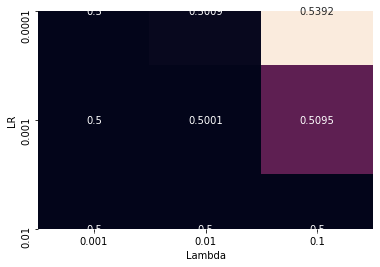

In [18]:
fig, ax = plt.subplots()
sns.heatmap(auc_df, cbar=False, annot=True, fmt=".4g")